### This model uses the diffraction from overlapping sample regions to solve the inversion symmetry problem and improve reconstruction quality

TODOs

* check whether performance is better with amplitude or intensity as model output
* make the model robust to arbitrary scaling/incorrect normalization of the diffracted intensity
* other ideas: fft based loss, gradient loss, vq-vae https://www.tensorflow.org/tutorials/generative/style_transfer#define_content_and_style_representations
* probe-based vs reconstruction-based support?

* Use perceptual loss for reconstruction. Need to set the weights. Read Perceptual Losses for Real-Time Style Transfer
and Super-Resolution
* Reflection invariance: do augmentation to reflect this. (done / n/a)
* consistency check on magnitude constraint (done)
* Fully Convolutional Networks for Semantic Segmentation, explore and discuss. Make a slide explaining the idea.
* Try MC Dropout https://arxiv.org/pdf/1511.02680.pdf
* Put poisson likelihood into data (done)
* read deep ensembles https://arxiv.org/pdf/1612.01474.pdf
* overlap condition -> resolution? 
* residual blocks?
* blur diffraction by 1 pixel in preprocessing or do pairwise linear interpolation. if blurring, then gaussian instead of poisson likelihood should be used.
* what does trainable option do?
* paper that ashwin mentioned
* does adding a random global phase break the symmetry?
* handle symmetry in perceptual loss


* Poisson augmentation
* smoothing interpolation
* hard constraint on diffraction norm using projection
* DFT channel dimension

misc notes:

clearing gpu memory: `for i in $(sudo lsof /dev/nvidia0 | grep python | awk '{print $2}' | sort -u); do sudo kill -9 $i; done`
https://github.com/tensorflow/tensorflow/issues/36465

In [1]:
import os
import tf_helper as hh
import fourier as f

import tensorflow_probability as tfp


tfk = hh.tf.keras
tfkl = hh.tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

path = '.'

from importlib import reload
import sys
import os
sys.path.append(path)
sys.path.append('PtychoNN/TF2/')

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model
import tensorflow_addons as tfa

import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
import matplotlib

import keras_helper

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

# importlib.reload(keras_helper)
# from keras_helper import *
from skimage.transform import resize

matplotlib.rcParams['font.size'] = 12

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)

2022-10-31 23:29:03.396108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 23:29:03.622666: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 23:29:04.220651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-31 23:29:04.220791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
import datasets

2022-10-31 23:29:06.672586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 23:29:06.673421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 23:29:06.673566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 23:29:06.673661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
from sklearn.utils import shuffle

In [4]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Oct 31 23:29:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   51C    P2    76W / 420W |   2660MiB / 24576MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

### Some training and probe parameters

In [5]:
h = w = N = 64
# offset between neighboring scan points, in pixels
offset = 4
gridsize = 2

nepochs=20
#wt_path = 'wts4' #Where to store network weights
wt_path = 'wts4.1'
batch_size = 16

filt = f.lowpass_g(.6, np.ones(N), sym = True)

# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

### Load experimental dataset

In [6]:
# ### Read experimental diffraction data and reconstructed images

# data_diffr = np.load(path+'/PtychoNN/data/20191008_39_diff.npz')['arr_0']
# data_diffr.shape

# #plt.matshow(np.log10(data_diffr[0,0]))

# data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
# for i in tqdm(range(data_diffr.shape[0])):
#     for j in range(data_diffr.shape[1]):
#         data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
#         data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

# real_space = np.load(path+'/PtychoNN/data/20191008_39_amp_pha_10nm_full.npy')
# amp = np.abs(real_space)
# ph = np.angle(real_space)
# amp.shape

# # fig,ax = plt.subplots(1,2,figsize=(20,10))
# # ax[0].imshow(amp[:,:,32,32])
# # ax[1].imshow(ph[:,:,32,32])

# ### Split data and then shuffle

# nlines = 100 #How many lines of data to use for training?
# nltest = 60 #How many lines for the test set?
# tst_strt = amp.shape[0]-nltest #Where to index from
# print(tst_strt)

# plt.imshow(probe)

# N = h
# assert h == w

# from sklearn.model_selection import train_test_split

# # def blowup(img):
# #     N = img.shape[0]
# #     assert img.shape[1] == N
# #     cropped = img[N // 4: -N // 4, N // 4: -N // 4]
# #     return resize(cropped.copy(), (N, N))

# def stack(a1, a2):
#     return np.array((a1, a2)).reshape((-1, N, N, 1))

# def augment_inversion(Y_I_train, Y_phi_train):
#     phi = stack(Y_phi_train, -Y_phi_train)
# #     phi_off = np.random.uniform(size = phi.size).reshape(phi.shape)
# #     phi = np.mod(phi + phi_off)
#     return stack(Y_I_train, Y_I_train[:, ::-1, ::-1, :]), stack(Y_phi_train, -Y_phi_train)

# X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

# ntrain = X_train.shape[0]*X_train.shape[1]
# ntest = X_test.shape[0]*X_test.shape[1]

# print(X_train.shape, X_test.shape)

# # # resize to fill the grid better
# # X_train = np.array([blowup(arr) for arr in X_train]) * probe[None, ..., None]
# # X_test = np.array([blowup(arr) for arr in X_test]) * probe[None, ..., None]

# tmp1, tmp2 = Y_I_train, Y_I_test

# # X_train = np.array(hh.pad_and_diffract(Y_I_train, h, w, pad=False)[1])
# # X_test = np.array(hh.pad_and_diffract(Y_I_test, h, w, pad=False)[1])

### Simulate ptychography measurements

In [7]:
nphotons = 1e8

def observe_amplitude(amplitude):
    """
    Sample photons from wave amplitudes by drwaing from the corresponding Poisson distributions
    """
    return tf.sqrt((tfd.Independent(tfd.Poisson(amplitude**2))).sample())# + 0.5


def count_photons(obj):
    return tf.math.reduce_sum(obj**2, (1, 2, 3))

def scale_nphotons(padded_obj):
    """
    Calculate the object amplitude normalization factor that gives the desired
    *expected* number of observed photons, averaged over an entire dataset.
    
    Returns a single scalar.
    """
    mean_photons = tf.math.reduce_mean(count_photons(padded_obj))
    norm = tf.math.sqrt(nphotons / mean_photons)
    return norm

def _preprocess(sample):
    # run ff diffraction
    amplitude = hh.pad_and_diffract(sample, h, w, pad=False)[1]
#     return amplitude
    # sample from Poisson observation likelihood
    observed_amp = observe_amplitude(amplitude)
    return observed_amp

def preprocess(Y_I_train, Y_phi_train, Y_I_test, Y_phi_test):    
    Y_I_train = Y_I_train *  probe[None, ..., None]
    Y_I_test = Y_I_test *  probe[None, ..., None]
    
    intensity_scale = scale_nphotons(Y_I_train).numpy()#nphotons / tf.reduce_mean(scale_nphotons(Y_I_train)).numpy()

    obj_train = intensity_scale * hh.combine_complex(Y_I_train, Y_phi_train)
    obj_test = intensity_scale * hh.combine_complex(Y_I_test, Y_phi_test)
    
    Y_I_train = tf.math.abs(obj_train)
    Y_I_test = tf.math.abs(obj_test)

    # Simulate diffraction
    X_train = (tf.data.Dataset.from_tensor_slices(obj_train)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_train = np.vstack(list(iter(X_train)))

    X_test = (tf.data.Dataset.from_tensor_slices(obj_test)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_test = np.vstack(list(iter(X_test)))

    X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test, intensity_scale =\
        X_train / intensity_scale, Y_I_train / intensity_scale, Y_phi_train,\
        X_test / intensity_scale, Y_I_test / intensity_scale, Y_phi_test, intensity_scale

    # TODO consolidate
    X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test =\
        togrid(X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test)
    
    X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test =\
        grid_to_channel(X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test)
    
    return X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test, intensity_scale
    

### Generate dataset based on randomly-oriented lines

In [8]:
reload(datasets)

<module 'datasets' from '/home/ollie/Documents/scratch/ptycho/datasets.py'>

In [9]:
np.random.seed(1)
Y_I_train = np.array([datasets.mk_lines_img(N + offset) for _ in range(15000)])[:, :, :, :1]
Y_I_test = np.array([datasets.mk_lines_img(N + offset) for _ in range(5000)])[:, :, :, :1]

# Normalize per set of overlapping images
Y_I_train /= Y_I_train.max(axis = (1, 2, 3))[:, None, None, None]
Y_I_test /= Y_I_test.max(axis = (1, 2, 3))[:, None, None, None]

_Y_I_train_full, _Y_I_test_full = Y_I_train, Y_I_test

In [10]:
Y_phi_train = np.zeros_like(Y_I_train)
Y_phi_test = np.zeros_like(Y_I_test)

In [11]:
Y_I_train, Y_phi_train = shuffle(Y_I_train, Y_phi_train, random_state=0)

In [12]:
tmp = Y_I_train

In [13]:
def _fromgrid(img):
    """
    Reshape (-1, gridsize, gridsize, N, N) to (-1, N, N, 1)
    """
    return tf.reshape(img, (-1, N, N, 1))

def fromgrid(*imgs):
    """
    Reshape (-1, gridsize, gridsize, N, N) to (-1, N, N, 1)
    """
    return [_fromgrid(img) for img in imgs]

def _togrid(img):
    """
    Reshape (-1, N, N, 1) to (-1, gridsize, gridsize, N, N)
    """
    return tf.reshape(img, (-1, gridsize, gridsize, N, N, 1))

def togrid(*imgs):
    """
    Reshape (-1, N, N, 1) to (-1, gridsize, gridsize, N, N)
    """
    return [_togrid(img) for img in imgs]

def _grid_to_channel(grid):
    """
    Reshape (-1, gridsize, gridsize, N, N) to (-1, N, N, gridsize * gridsize)
    """  
    img = tf.transpose(grid, [0, 3, 4, 1, 2, 5], conjugate=False)
    _, ww, hh = img.shape[:3]
    img = tf.reshape(img, (-1, ww, hh, gridsize**2))
    return img

def _flat_to_channel(img):
    img = tf.reshape(img, (-1, gridsize**2, h, w))
    img = tf.transpose(img, [0, 2, 3, 1], conjugate=False)
    return img

def grid_to_channel(*grids):
    return [_grid_to_channel(g) for g in grids]

def flatten_overlaps(img, fmt = 'flat'):
    grid = tf.reshape(
        tf.compat.v1.extract_image_patches(img, [1, N, N, 1], [1, offset, offset, 1],
                                              [1, 1, 1, 1], padding = 'VALID'),
        (-1, gridsize, gridsize, N, N, 1))
    if fmt == 'flat':
        return _fromgrid(grid)
    elif fmt == 'grid':
        return grid
    elif fmt == 'channel':
        return _grid_to_channel(grid)
    else:
        raise ValueError

In [14]:
flattened = [flatten_overlaps(imgs) for imgs in [Y_I_train, Y_phi_train, Y_I_test, Y_phi_test]]

In [15]:
X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test, intensity_scale =\
    preprocess(*flattened)

(Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape
#Y_I_train.max(axis = 3).max(axis = 2).max(axis = 1).argmax()

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


(TensorShape([5000, 64, 64, 4]),
 TensorShape([5000, 64, 64, 4]),
 TensorShape([15000, 64, 64, 4]))

In [16]:
print(intensity_scale, '\n',
      (np.max(Y_I_train, axis = (1, 2, 3)).mean() * intensity_scale)**2, '\n',
      (Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape)

860.7317432246338 
 631130.4128434637 
 (5000, 64, 64, 4) (5000, 64, 64, 4) (15000, 64, 64, 4)


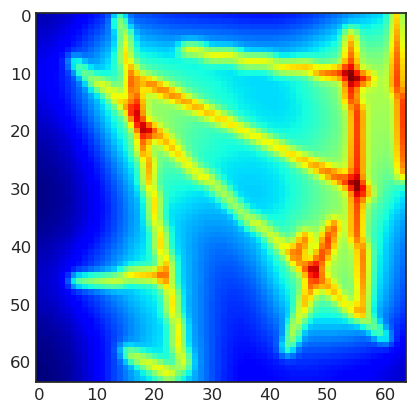

In [17]:
plt.imshow(flattened[0][2], cmap = 'jet')

### Norm conservation consistency check:

In [18]:
print(np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0]))

import fourier as f
def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / np.sqrt(h * w))

1.0000174


### Inversion symmetry check:

In [19]:
assert np.isclose(normed_ff_np(Y_I_train[0, :, :, 0]),
            tf.math.conj(normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])), atol = 1e-6).all()

#normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(Y_I_train[0, :, :, 0]).sum()

### np / tf consistency check:

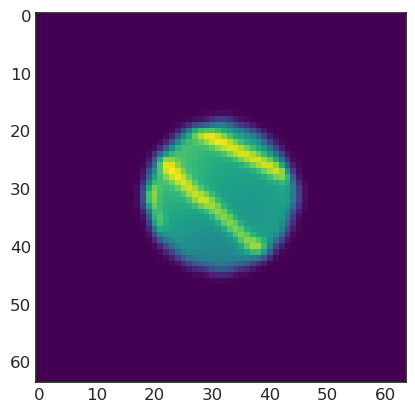

In [20]:
plt.imshow(Y_I_train[0, :, :, 0])

### Number of photons consitency check

In [21]:
np.log10(np.sum((X_train[:, :, :] * intensity_scale)**2, axis = (1, 2))).mean()

7.962887

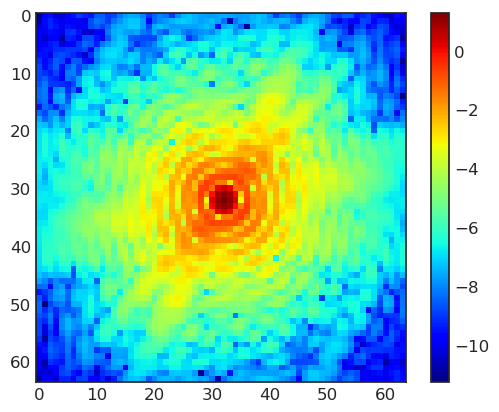

In [22]:
i = 0

plt.imshow(np.log(normed_ff_np
                  (np.array(hh.combine_complex(Y_I_train, Y_phi_train))[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

/tmp/ipykernel_443781/2541740429.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_train[0, :, :, 1]), cmap = 'jet')


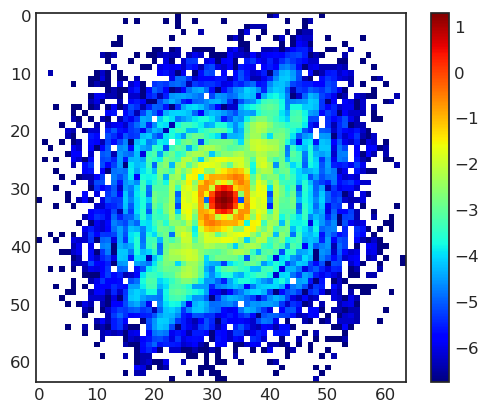

In [23]:
#mark
plt.imshow(np.log(X_train[0, :, :, 1]), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [24]:
# %load keras_helper.py
#Keras modules
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, UpSampling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Input
import numpy as np

def Conv_Pool_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = MaxPool2D((p1, p2), padding=padding, data_format=data_format)(x0)
    return x0

def Conv_Up_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last',
        activation = 'relu'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation=activation, padding=padding, data_format=data_format)(x0)
    x0 = UpSampling2D((p1, p2), data_format=data_format)(x0)
    return x0

In [25]:
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.layers import Lambda
import math

reload(hh)

<module 'tf_helper' from '/home/ollie/Documents/scratch/ptycho/tf_helper.py'>

In [26]:
plt.rcParams["figure.figsize"] = (10, 10)

def get_mask(input, support_threshold):
    mask = tf.where(tf.math.abs(input) > support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    return mask

def symmetrize(arr):
    return (arr + arr[::-1, ::-1]) / 2

def symmetrize_3d(arr):
    return (arr + arr[:, ::-1, ::-1]) / 2

def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)

def summarize(i, channel = 0):
    #norm =  (np.absolute(b)[i].max() / tmp2[i].max())
    # vmax = tmp2[i].max() * norm
    vmin = 0
    vmax = np.absolute(b)[i].max()

    aa, bb = 3, 3
    plt.subplot(aa, bb, 1)
    plt.title('True amp.\n(illuminated)')
    #cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((Y_I_test[i, :, :, channel]), cmap = 'jet')
    
    plt.subplot(aa, bb, 2)
    plt.title('Reconstructed amp.\n(illuminated)')
    cropshow((np.absolute(b))[i] * probe[..., None], cmap = 'jet')
#     cropshow((np.absolute(b))[i] * probe[..., None], vmin = np.min(Y_I_test[i]),
#              vmax = np.max(Y_I_test[i]), cmap = 'jet')

    plt.subplot(aa, bb, 3)
    plt.title('True phase')
    cropshow(((Y_phi_test * (probe > .01)[..., None]))[i, :, :, channel], cmap = 'jet')

    plt.subplot(aa, bb, 4)
    plt.title('True amp. (full)')
    cropshow((_Y_I_test_full[i, :, :, channel]), cmap = 'jet')

    plt.subplot(aa, bb, 5)
    plt.title('Reconstructed amp. (full)')
    cropshow((np.absolute(b))[i], cmap = 'jet')

    plt.subplot(aa, bb, 6)
    plt.title('Reconstructed phase')
    cropshow((np.angle(b) * (probe > .01)[..., None])[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 7)
    plt.title('True diffraction')
    plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')
    
    plt.subplot(aa, bb, 8)
    plt.title('Recon diffraction')
    plt.imshow(np.log(a)[i, :, :, channel], cmap = 'jet')
    
def plt_metrics(loss_type = 'MAE'):
    hist=history
    epochs=np.asarray(history.epoch)+1

    %matplotlib inline
    import matplotlib
    plt.style.use('seaborn-white')
    matplotlib.rc('font',family='Times New Roman')
    matplotlib.rcParams['font.size'] = 12

    f, axarr = plt.subplots(2, sharex=True, figsize=(12, 8))

    axarr[0].set(ylabel='Loss')
    axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Diffraction {} Training'.format(loss_type))
    axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Diffraction {} Validation'.format(loss_type))
    axarr[0].grid()
    axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

    axarr[1].set(ylabel='Loss')
    axarr[1].plot(epochs,hist.history['padded_obj_loss'], 'C0o', label='Object {} Training'.format(loss_type))
    axarr[1].plot(epochs,hist.history['val_padded_obj_loss'], 'C0-', label='Object {} Validation'.format(loss_type))
    axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
    plt.xlabel('Epochs')
    plt.tight_layout()
    #plt.semilogy()
    axarr[1].grid()

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16

# vgg = VGG16(weights='imagenet', include_top=False, input_shape=(N // 2,N // 2,3))
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(N, N, 3))
vgg.trainable = False

outputs = [vgg.get_layer('block2_conv2').output]
feat_model = Model(vgg.input, outputs)
# feat_model.trainable = False

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

def total_variation_loss(target, pred):
    pred = tf.keras.layers.AveragePooling2D(padding = 'valid')(pred)
    x_deltas, y_deltas = high_pass_x_y(pred)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

pp = tfk.Sequential([
    Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
])
def perceptual_loss(target, pred):
    """
    """
    target = pp(target)
    pred = pp(pred)
    
    activatedModelVal = feat_model(pred)
    actualModelVal = feat_model(target)
    return meanSquaredLoss(gram_matrix(actualModelVal),gram_matrix(activatedModelVal))

def symmetrized_loss(target, pred, loss_fn):
    """
    Calculate loss function on an image, taking into account that the prediction may be
    coordinate-inverted relative to the target
    """
    abs1 = (target)
    abs2 = (pred)
    abs3 = abs2[:, ::-1, ::-1, :]
    target_sym = (symmetrize_3d(target))
    a, b, c = loss_fn(abs1, abs2), loss_fn(abs1, abs3), loss_fn(target_sym, pred)
    return tf.minimum(a, 
                      tf.minimum(b, c))

def amplitude_difference(target, pred):
    """
    Calculate object MAE, taking into account that the prediction may be inverted
    """
    abs1 = tf.math.abs(target)
    abs2 = tf.math.abs(pred)
    return symmetrized_loss(target, pred, tf.keras.losses.MeanAbsoluteError())

def symmetrized_perceptual_loss(target, pred):
    return symmetrized_loss(target, pred, perceptual_loss)

def get_cm_agg(volumes):
    # Make array of coordinates (each row contains three coordinates)
    jj, kk = tf.meshgrid(tf.range(N), tf.range(N), indexing='ij')
    coords = tf.stack([tf.reshape(jj, (-1,)), tf.reshape(kk, (-1,))], axis=-1)
    coords = tf.cast(coords, tf.float32)
    # Rearrange input into one vector per volume
    volumes_flat = tf.reshape(volumes, [-1, N * N, volumes.shape[-1]])
    # Compute total mass for each volume
    total_mass = tf.reduce_sum(volumes_flat, axis=1)
    # Compute centre of mass
    centre_of_mass = tf.reduce_sum(volumes_flat * coords, axis=1) / total_mass

    return tf.math.reduce_mean(centre_of_mass[:, 0]) + tf.math.reduce_mean(centre_of_mass[:, 1])

def meanSquaredLoss(y_true,y_pred):
    return tf.reduce_mean(tf.keras.losses.MSE(y_true,y_pred))
# perceptual_loss(tf.convert_to_tensor(X_test[:50]), tf.convert_to_tensor(X_test[:50]))

In [28]:
tprobe_small = tprobe[16:-16, 16:-16, :]

In [29]:
reload(hh)

<module 'tf_helper' from '/home/ollie/Documents/scratch/ptycho/tf_helper.py'>

In [30]:
tf.keras.backend.clear_session()
np.random.seed(2)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

input_img = Input(shape=(h, w, gridsize**2), name = 'input') 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')

encoded=x

#Decoding arm for amplitude
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)
decoded1 = Lambda(lambda x: sigmoid(x), name='amp')(decoded1)

#Decoding arm for phase
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)
decoded2 = Lambda(lambda x: math.pi * tanh(x), name='phi')(decoded2)

obj = Lambda(lambda x: hh.combine_complex(x[0], x[1]),
                     name='obj')([decoded1, decoded2])

padded_obj = tfkl.ZeroPadding2D(((h // 4) , (w // 4)), name = 'padded_obj')(obj)
padded_obj_2 = tfkl.ZeroPadding2D((offset // 2 , offset // 2), name = 'padded_obj_2')(padded_obj)

# Extract overlapping regions of the object
padded_objs_with_offsets = Lambda(lambda x: flatten_overlaps(x, fmt = 'flat'), name = 'padded_objs_with_offsets')(padded_obj_2)
# Apply the probe
padded_objs_with_offsets = Lambda(lambda x: tf.cast(tprobe, tf.complex64) * x,
                                  name = 'padded_objs_with_offsets_illuminated')(padded_objs_with_offsets)

# TODO refactor
# Diffracted amplitude
padded_objs_with_offsets, pred_diff = hh.pad_and_diffract(padded_objs_with_offsets, h, w, pad=False)

# Reshape
pred_diff = Lambda(lambda x: _flat_to_channel(x), name = 'pred_diff_channels')(pred_diff)

pred_intensity = tfpl.DistributionLambda(lambda t: 
                                       (tfd.Independent(
                                           tfd.Poisson(
                                               ((t * intensity_scale)**2))
                                       )))(pred_diff)

# TODO should noise respect the nyquist criterion?
def mul_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1, dtype=tf.float32)
        noise_img = image * noise
    return noise_img

negloglik = lambda x, rv_x: -rv_x.log_prob((x))
# norm_loss = lambda target, pred: tf.abs(tf.norm(target) - tf.norm(pred))

# The first output exposes the real space object reconstruction and though it does not contribute to the
# training loss, it's used to calculate reconstruction errors for evaluation
autoencoder = Model([input_img], [padded_obj, pred_diff, pred_intensity, pred_diff])


Instructions for updating:
ksizes is deprecated, use sizes instead


Instructions for updating:
ksizes is deprecated, use sizes instead


In [31]:
autoencoder.compile(optimizer='adam',
     loss=['mean_absolute_error', 'mean_absolute_error', negloglik, total_variation_loss],
     loss_weights = [0., 0., 1., 0.])

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   1184        ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

None


In [32]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

checkpoints= tf.keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.h5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)


history=autoencoder.fit([X_train], [Y_I_train, X_train, (intensity_scale * X_train)**2,
                                   X_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=12, validation_split = 0.05, callbacks=[reduce_lr, earlystop, checkpoints])

# history=autoencoder.fit([X_train], [X_train, Y_I_train, dummy_input], shuffle=True, batch_size=batch_size, verbose=1, 
#                            epochs=2, validation_split = 0.05, callbacks=[reduce_lr, earlystop, checkpoints])

# a, b, c_diffraction, reg = autoencoder.predict([X_test])
b, a, reg, L2_error = autoencoder.predict([X_test])

Epoch 1/12


2022-10-31 23:32:40.333112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


891/891 [==============================] - ETA: 0s - loss: 16839470.0000 - padded_obj_loss: 0.0797 - pred_diff_channels_loss: 0.0082 - distribution_lambda_loss: 16839470.0000 - pred_diff_channels_1_loss: 0.0353
Epoch 1: val_loss improved from inf to 7976188.50000, saving model to wts4.1/weights.01.h5
891/891 [==============================] - 14s 12ms/step - loss: 16839470.0000 - padded_obj_loss: 0.0797 - pred_diff_channels_loss: 0.0082 - distribution_lambda_loss: 16839470.0000 - pred_diff_channels_1_loss: 0.0353 - val_loss: 7976188.5000 - val_padded_obj_loss: 0.0762 - val_pred_diff_channels_loss: 0.0072 - val_distribution_lambda_loss: 7976188.5000 - val_pred_diff_channels_1_loss: 0.0362 - lr: 0.0010
Epoch 2/12
890/891 [============================>.] - ETA: 0s - loss: 6302025.5000 - padded_obj_loss: 0.0704 - pred_diff_channels_loss: 0.0065 - distribution_lambda_loss: 6302025.5000 - pred_diff_channels_1_loss: 0.0344
Epoch 2: val_loss improved from 7976188.50000 to 5087340.00000, saving

157/157 [==============================] - 9s 53ms/step


In [33]:
a.shape

(5000, 64, 64, 4)

In [34]:
i = 0
# consistency check: should be close to equal
np.sum(tf.math.abs(a[i])**2), np.sum(tf.math.abs(X_test[i])**2)

(565.41785, 574.80884)

/tmp/ipykernel_443781/4029023302.py:54: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


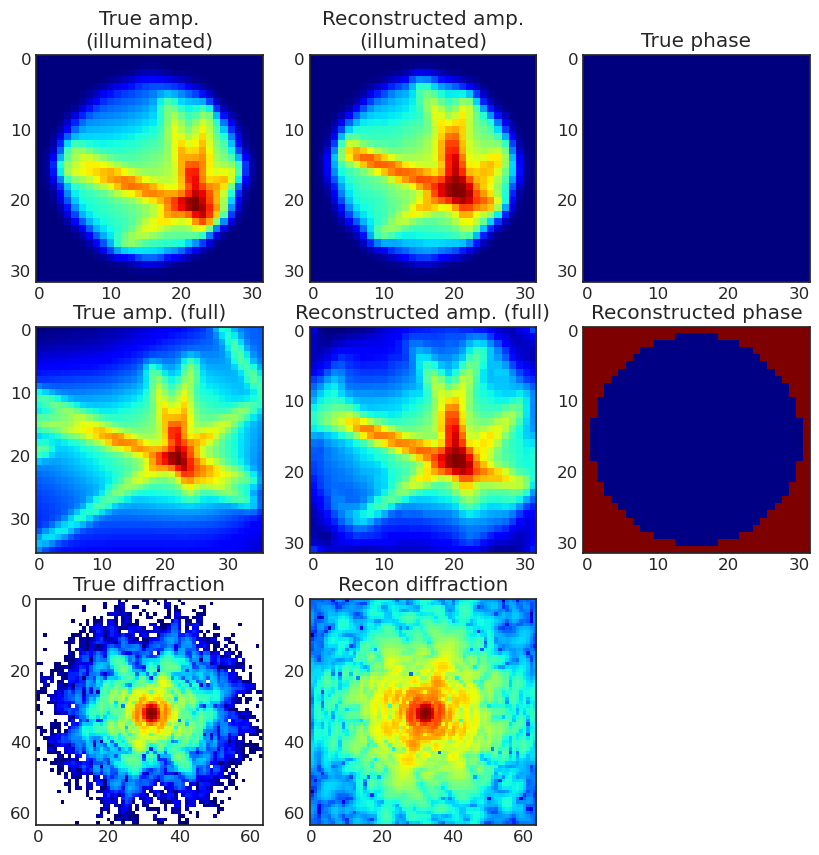

In [35]:
summarize(0, channel = 0)

/tmp/ipykernel_349452/4131967749.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


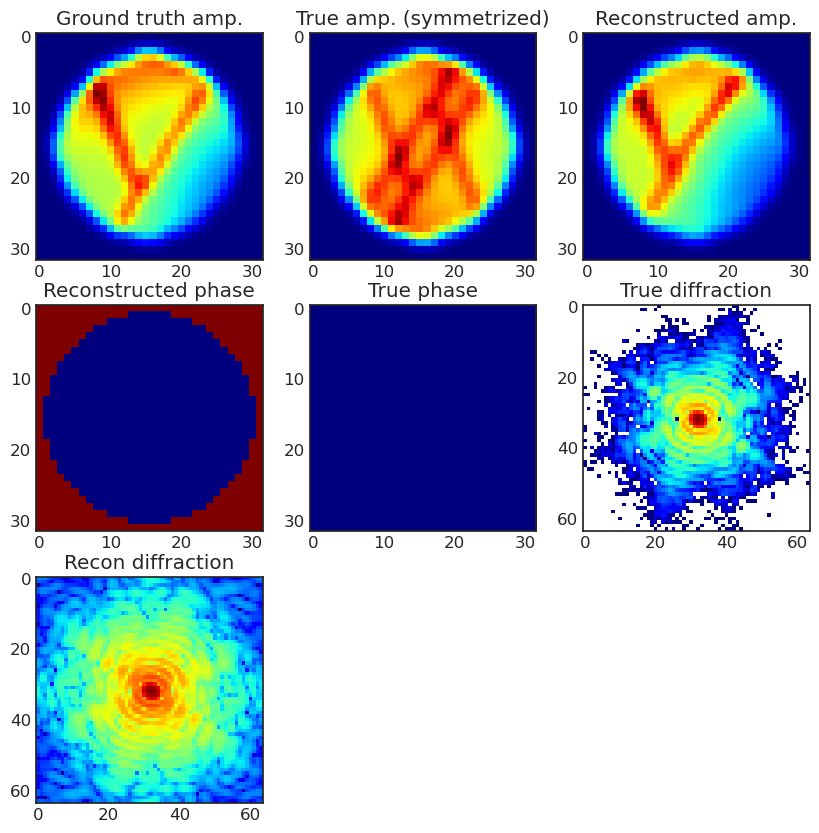

In [65]:
summarize(10, channel = 0)

Pre-overlap equivalent:

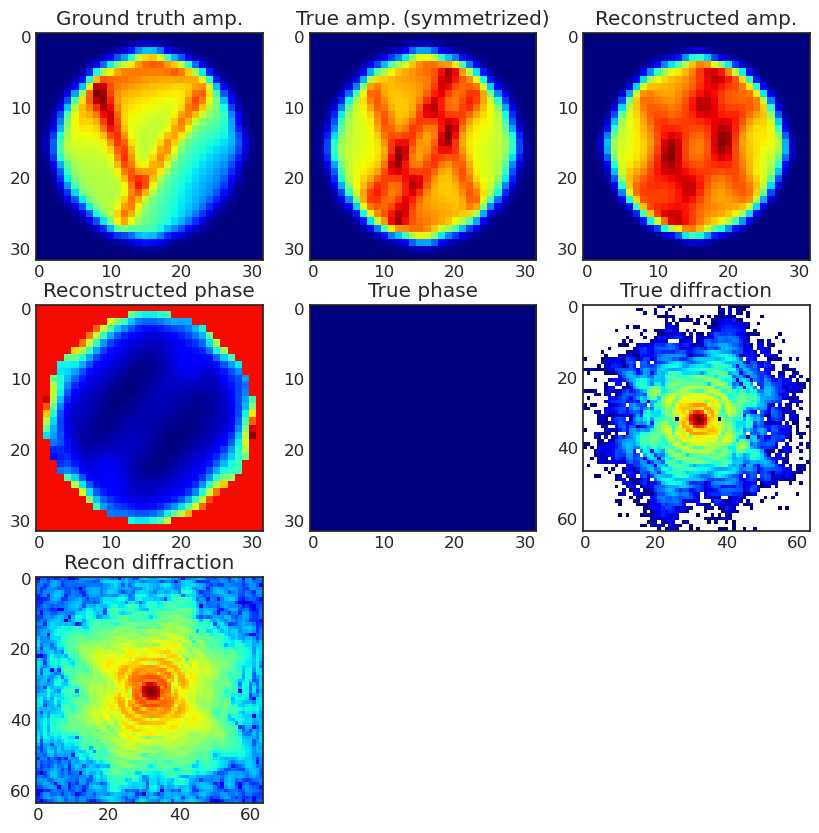

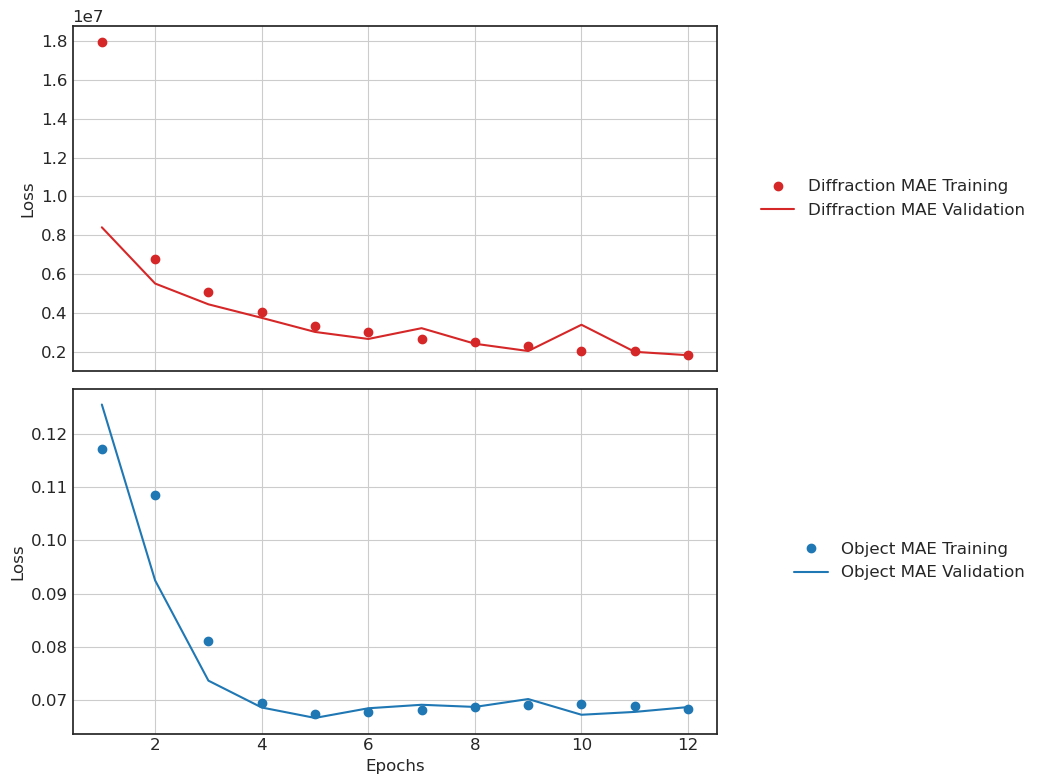

In [43]:
plt_metrics()

### More examples of reconstructions:

/tmp/ipykernel_349452/4131967749.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


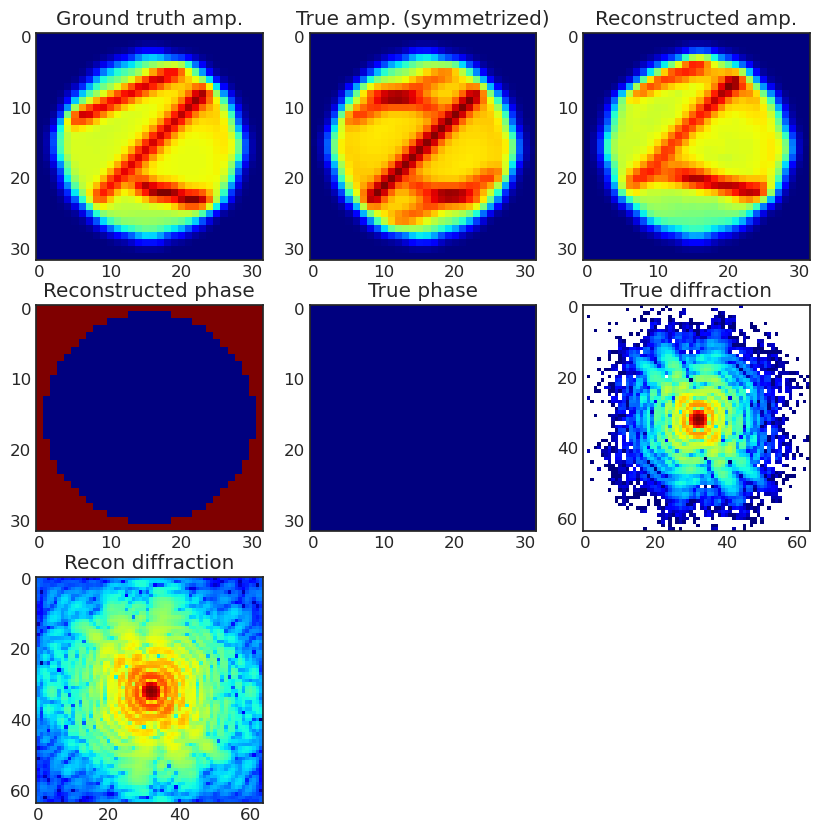

In [74]:
i = 501
summarize(i)

/tmp/ipykernel_349452/4131967749.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


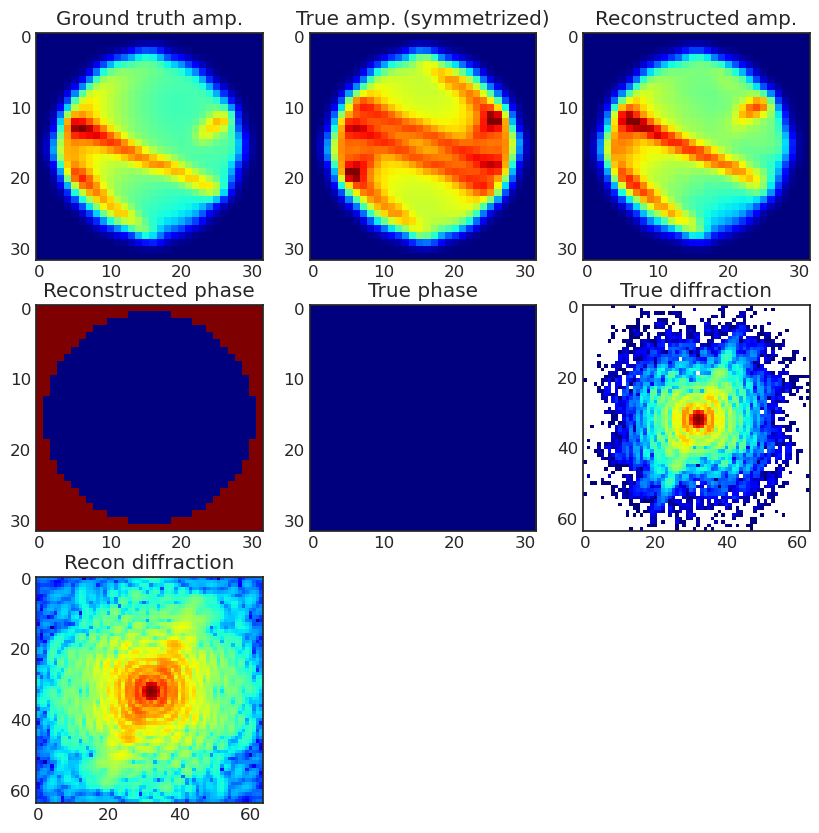

In [75]:
summarize(505)

### More reconstruction examples:

/tmp/ipykernel_349452/4131967749.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


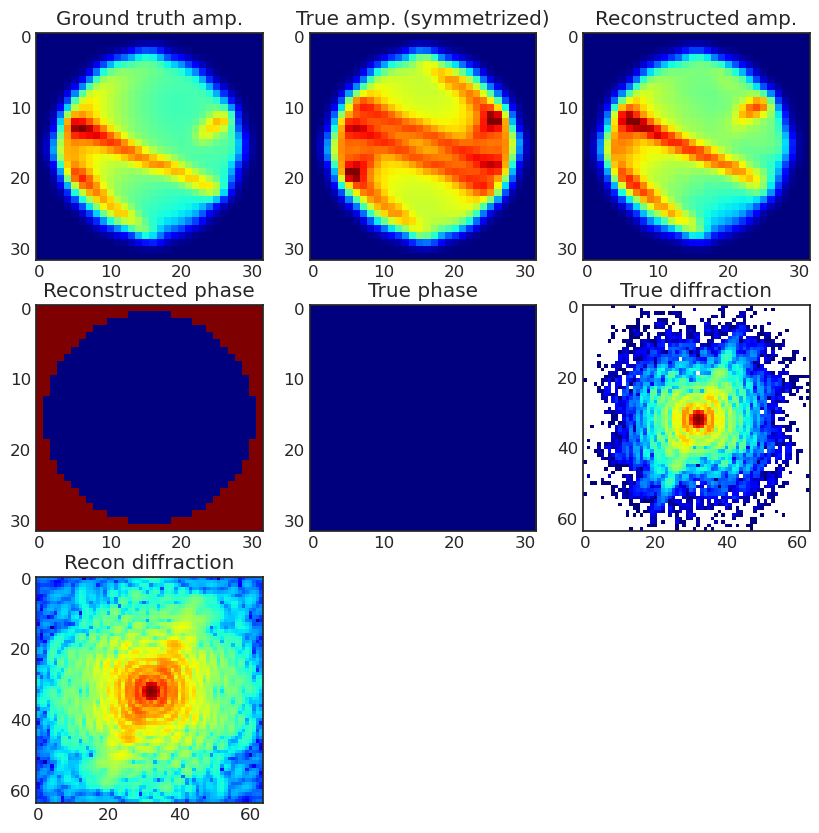

In [72]:
summarize(505)

In [1]:
plt.imshow(np.log(.2 + np.abs((a[i, :, :, 0] - X_test[i, :, :, 0]) / (X_test[i, :, :, 0] + 1e-9))), cmap ='jet')
plt.colorbar()

NameError: name 'plt' is not defined

In [84]:
tmp2 = Y_I_test

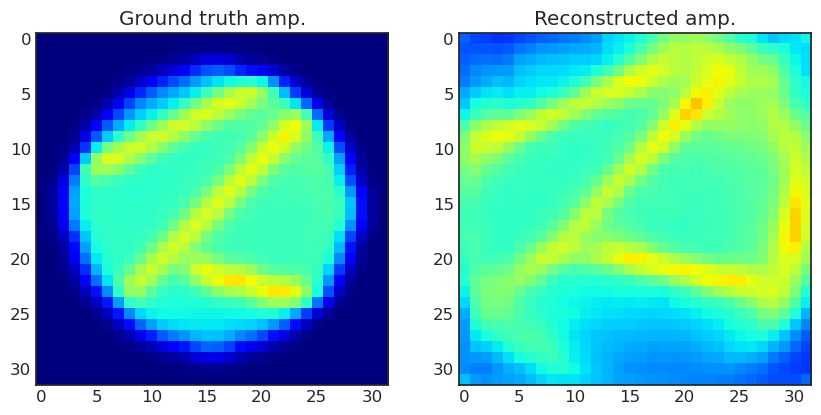

In [89]:
off = 1
# norm =  (np.absolute(b)[i] / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i, :, :, 0]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i, :, :, 0], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

In [44]:
# !ln ../xrd_clustering/notebooks/visualization.py
import visualization as vis
reload(vis)

<module 'visualization' from '/home/ollie/mnt/sys/Documents/scratch/ptycho/visualization.py'>

15 epochs:

diffraction reconstruction


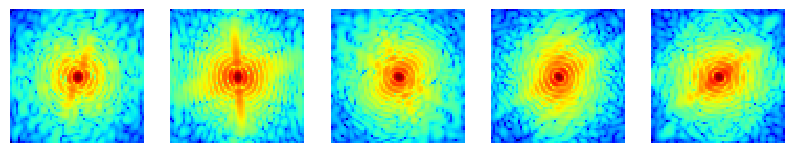

diffraction ground truth


/tmp/ipykernel_351447/1178352548.py:10: RuntimeWarning: divide by zero encountered in log
  vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])


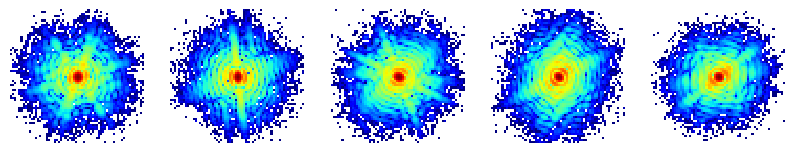

object reconstruction (amp)


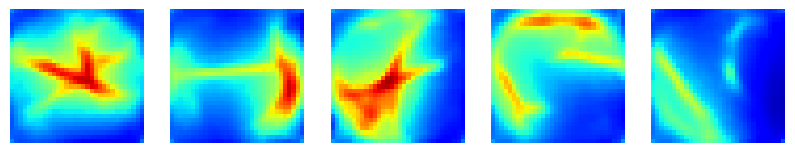

object ground truth


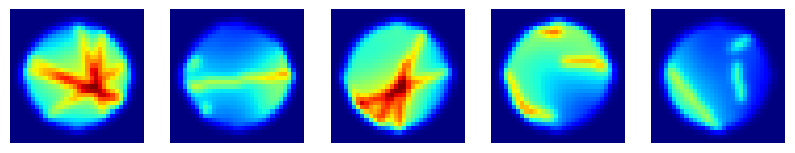

In [45]:
off = 5

vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + off])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + off])

print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a[:, :, :, 0]))[i:i + off])

print('diffraction ground truth')
vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])

print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16, 0])[i:i + off], vmin = vmin, vmax = vmax)
# print('object reconstruction (phase)')
# vis.display_imgs(np.angle(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16, 0][i:i + off], vmin = vmin, vmax = vmax)

diffraction reconstruction


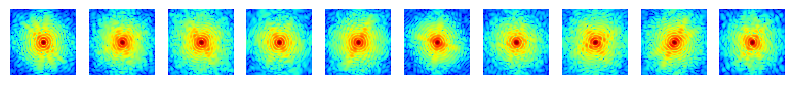

diffraction ground truth


/tmp/ipykernel_349452/125405235.py:5: RuntimeWarning: divide by zero encountered in log
  vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + 10])


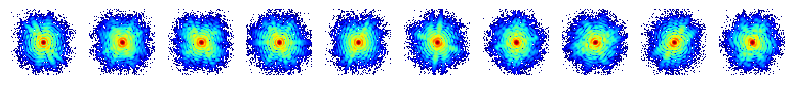

object reconstruction (amp)


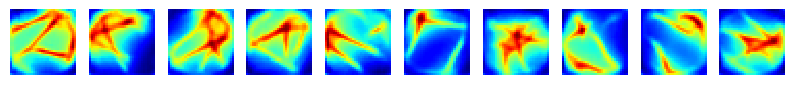

object ground truth


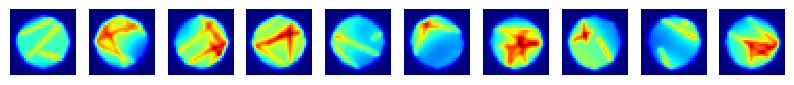

In [106]:
vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + 10])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + 10])

print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a[:, :, :, 0]))[i:i + 10])

print('diffraction ground truth')
vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + 10])

print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
# print('object reconstruction (phase)')
# vis.display_imgs(np.angle(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16, 0][i:i + 10], vmin = vmin, vmax = vmax)

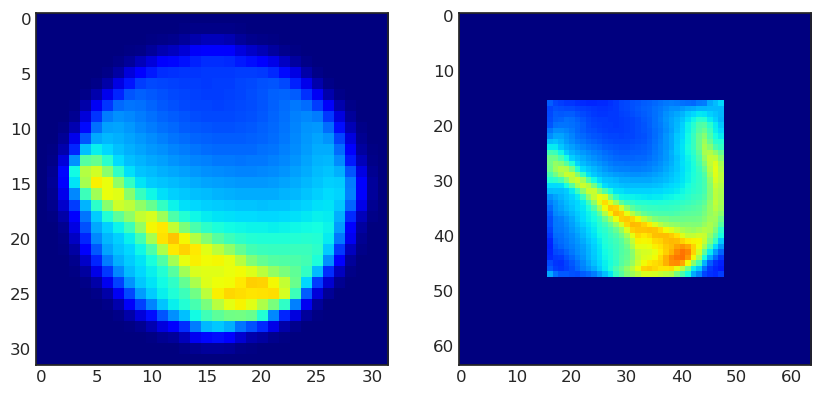

In [108]:
off = 1
i = 607

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.imshow((Y_I_test[i, 16:-16, 16:-16, 0]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.imshow((np.absolute(b[:, :, :, 0]))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

## save model

In [249]:
history.history.keys()

dict_keys(['loss', 'pred_amplitude_loss', 'padded_obj_loss', 'pred_amplitude_1_loss', 'val_loss', 'val_pred_amplitude_loss', 'val_padded_obj_loss', 'val_pred_amplitude_1_loss', 'lr'])

In [250]:
np.save(path+'str_history', history.history)

In [251]:
# model.load_weights(checkpoint_filepath)

In [68]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))